In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera Calibration

### BLOCK: Calibration-1 : Build image points and object points for calibration

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

### BLOCK: Calibration-2 - Test and ensure calibration works

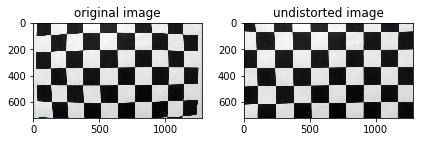

In [4]:
figure , ax = plt.subplots(1,2)
figure.tight_layout()

calibration_example_image = cv2.imread('camera_cal/calibration1.jpg')
ax[0].set_title('original image')
ax[0].imshow(calibration_example_image)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
calibration_example_image_undistort = cv2.undistort(calibration_example_image, mtx, dist, None, mtx)
ax[1].set_title('undistorted image')
ax[1].imshow(calibration_example_image_undistort)

figure.savefig('output_images/undistortion_example.jpg')

### Load test image

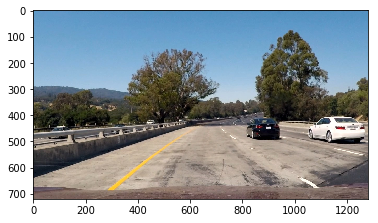

In [5]:
original = cv2.cvtColor(cv2.imread('test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(original)

### Calibration method and test

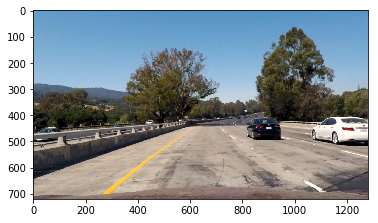

In [6]:
def undistort(img):
    #img = np.copy(src)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

undistorted = undistort(original)
plt.imshow(undistorted)

## Thresholding to get binary image

To get binary, I implemented 3 different method based on the previous lessions so far.

Text(0.5,1,'Combined')

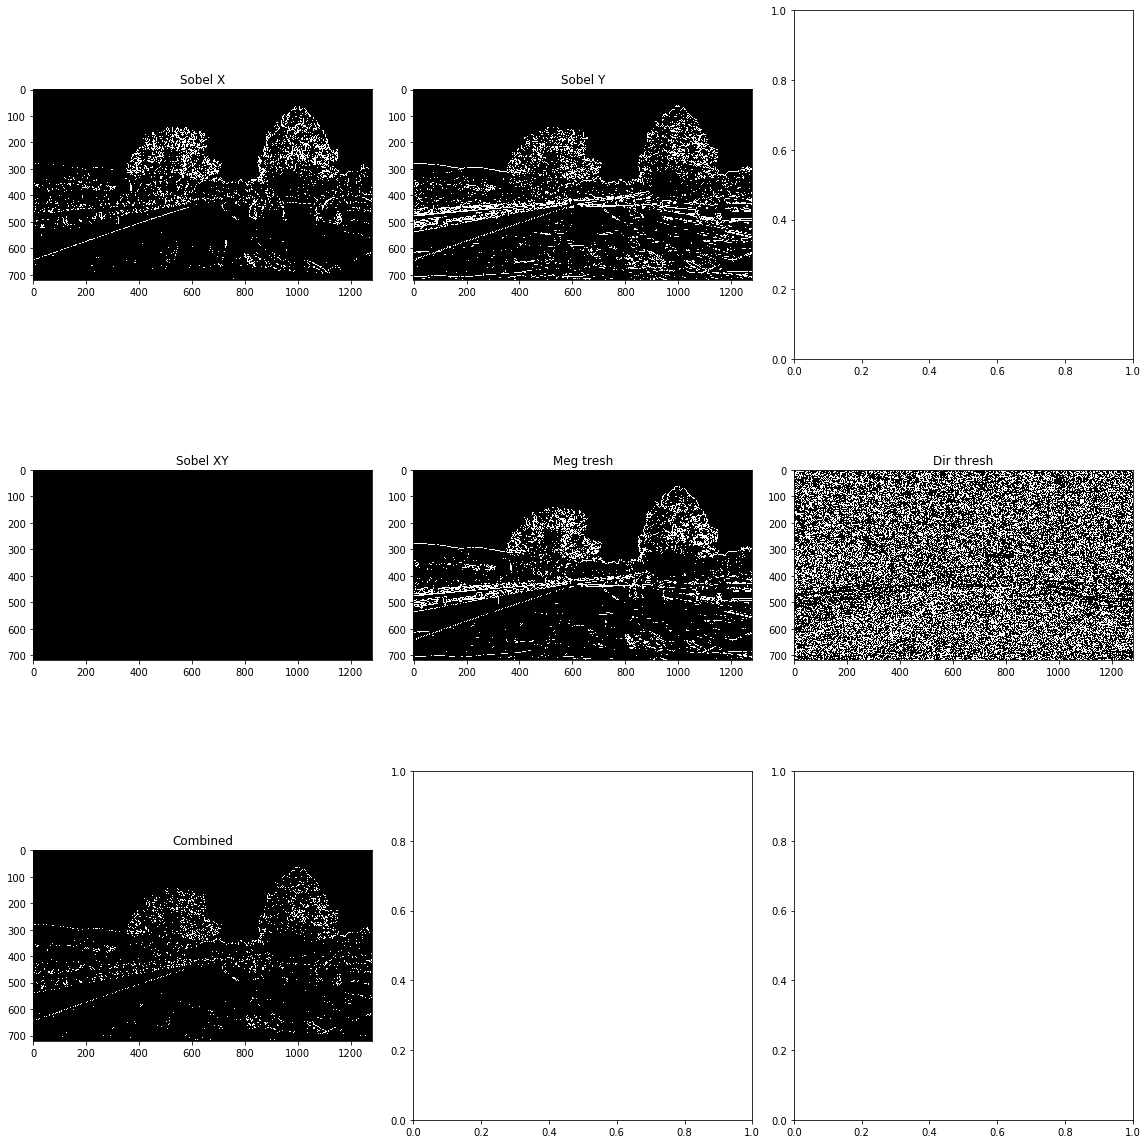

In [10]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# This method will be used later part of the project
def gradient_threshold(img):
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undistort, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(undistort, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    gradxy = np.zeros_like(undistort)
    gradxy[((gradx == 1) & (grady == 1))] = 1

    mag_binary = mag_thresh(undistort, sobel_kernel=ksize, thresh=(30, 100))
    dir_binary = dir_threshold(undistort, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined
    

# However, let's try them out and visualize for tuning

ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=ksize, thresh=(20, 100))
gradxy = np.zeros_like(undistorted)
gradxy[((gradx == 1) & (grady == 1))] = 1

mag_binary = mag_thresh(undistorted, sobel_kernel=ksize, thresh=(30, 100))
dir_binary = dir_threshold(undistorted, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Render for comparison
fig, ax = plt.subplots(3, 3, figsize=(16,16))
fig.tight_layout()
ax[0][0].imshow(gradx,cmap='gray')
ax[0][0].set_title('Sobel X')
ax[0][1].imshow(grady,cmap='gray')
ax[0][1].set_title('Sobel Y')
ax[1][0].imshow(gradxy, cmap='gray')
ax[1][0].set_title('Sobel XY')
ax[1][1].imshow(mag_binary, cmap='gray')
ax[1][1].set_title('Meg tresh')
ax[1][2].imshow(dir_binary, cmap='gray')
ax[1][2].set_title('Dir thresh')
ax[2][0].imshow(combined, cmap='gray')
ax[2][0].set_title('Combined')


### Color and Gradient combination thresholding

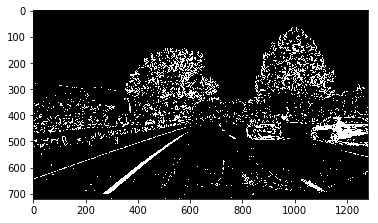

In [13]:
def get_binary(img):
    
    #img = np.copy(src)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # sxbinary = gradient_threshold(img)
    
    s_thresh_min = 150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    #combined_binary = cv2.GaussianBlur(combined_binary, (3, 3), 0)
    
    return combined_binary

binary = get_binary(undistorted)
plt.imshow(binary, cmap='gray')
plt.imsave('output_images/binary_example.jpg', binary)

### Masking image with region of interest

Now let's apply mask with region of interest. This will remove unnecessary area for lane finding so we can expect more accurate lane line detection.

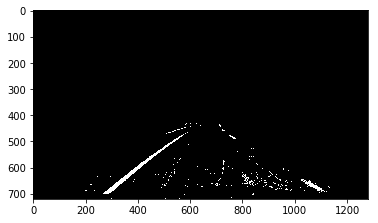

In [225]:
def region_of_interest(img, vertices):
    
    #img = np.copy(src)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

img_shape = [binary.shape[1], binary.shape[0]]

vertices = np.array([
    [
        (img_shape[0]/10*4.5,img_shape[1]/10*6),
        (img_shape[0]/10*0.5,img_shape[1]/10*10),
        (img_shape[0]/10*9.5,img_shape[1]/10*10),
        (img_shape[0]/10*5.5,img_shape[1]/10*6)
    ]
], dtype=np.int32)

binary_masked = region_of_interest(binary, vertices)
plt.imshow(binary_masked, cmap='gray')
plt.imsave('output_images/binary_masked_example.jpg', binary_masked)

## Warp image to bird-view

### Test and validate parameters for warp

To test parameters, I drew parallelogram on top of undistort image and warp it to bird-view. I could find that vertical lines looks almost parallel.

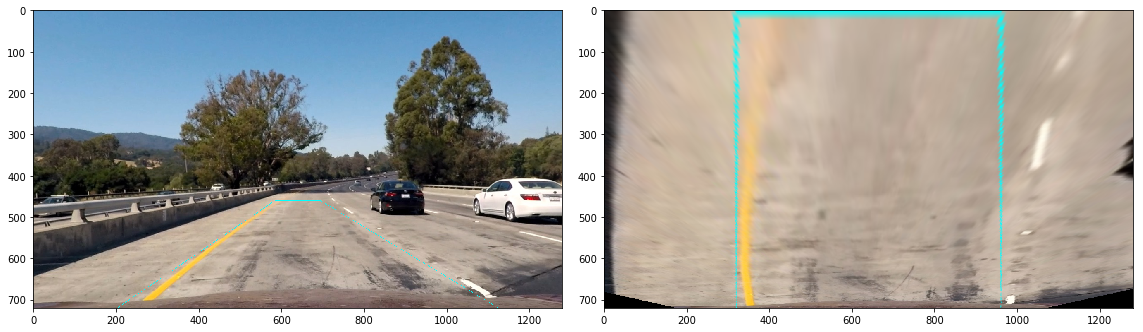

In [226]:
def warp_for_validation(img):
    
    #img = np.copy(src)
    img_size = (img.shape[1],img.shape[0])

    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    pts = np.array( [
        [(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(img,[pts],True,(0,255,255))

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return img, warped, M

img_validation,warped_validation, M = warp_for_validation(undistorted)
fig, ax = plt.subplots(1,2,figsize=(16,12))
fig.tight_layout()

ax[0].imshow(img_validation)
ax[1].imshow(warped_validation)
fig.savefig('output_images/warp_validation_process.jpg')

### Now we can implement warp method for later use

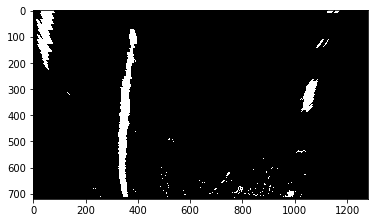

In [227]:
def warp(img):
    
    #img = np.copy(src)
    img_size = (img.shape[1],img.shape[0])

    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    

    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, M_inv

warped, M, M_inv = warp(binary_masked)
plt.imshow(warped,cmap='gray')
plt.imsave('output_images/warp_example.jpg', warped)

## Line finding

In [228]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

### Window search

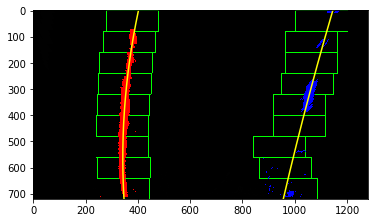

In [229]:
def find_lane_pixels(img):
    
    #img = np.copy(src)

    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    out_img = np.dstack((img, img, img))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    margin = 100
    minpix = 30

    window_height = np.int(img.shape[0]//nwindows)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = (
            (nonzeroy >= win_y_low) & 
            (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) & 
            (nonzerox < win_xleft_high)).nonzero()[0]
            
        good_right_inds =(
            (nonzeroy >= win_y_low) &
            (nonzeroy < win_y_high) &
            (nonzerox >= win_xright_low) &
            (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def window_search(img):
    
    #img = np.copy(src)
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty , leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_cr = np.polyfit(lefty * ym_per_pix , leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)


    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, left_fit, right_fit, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty

out_img, left_fit, right_fit, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty  = window_search(warped)
plt.imshow(out_img)
plt.imsave('output_images/window_search_example.jpg', out_img)

### Search with region of interest around previous polynomials

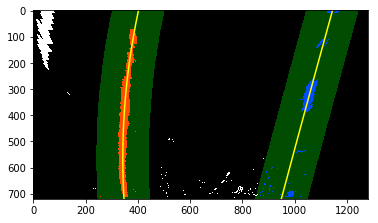

In [230]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_cr = np.polyfit(lefty * ym_per_pix , leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit, left_fit_cr, right_fit_cr

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = (
        (nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & 
        (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin))
    )
    
    right_lane_inds = (
        (nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & 
        (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin))
    )
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, new_left_fit, new_right_fit, new_left_fit_cr, new_right_fit_cr = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, new_left_fit, new_right_fit, new_left_fit_cr, new_right_fit_cr, left_fitx, right_fitx, ploty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_fit, right_fit, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty = search_around_poly(warped, left_fit, right_fit)

# View your output
plt.imshow(result)
plt.imsave('output_images/search_with_region_of_interest_example.jpg', result)

## Measuring metrics

## Measure curvature in meter

In [231]:
def measure_curvature_real(warped, left_fit_cr, right_fit_cr):

    y_eval = np.max(warped.shape[0] - 1)
    
    left_curverad = ((1 + (2 * left_fit_cr[0] * (y_eval*ym_per_pix) + left_fit_cr[1])**2)**(3/2))/np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * (y_eval*ym_per_pix) + right_fit_cr[1])**2)**(3/2))/np.absolute(2*right_fit_cr[0])
    curverad = (left_curverad + right_curverad) / 2
    
    return curverad

# Calculate the radius of curvature in pixels for both lane lines
curverad = measure_curvature_real(warped, left_fit_cr, right_fit_cr)

print(curverad)

12230.9190554


### Measure offset from center of the lane in meter

In [232]:
def measure_offset(warped, left_fit, right_fit):
    
    y_eval = np.max(warped.shape[0] - 1)
    
    left_line_position = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_line_position = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    
    center = (left_line_position + right_line_position)/2
    
    offset = (640 - center) * xm_per_pix
    return offset

offset = measure_offset(warped, left_fit, right_fit)
print(offset)

-0.0421589932021


## Drawing

I implemented draw method which draws vaious data on top of undistorted lane image. 
On each frame, the method will draw it's data, those are

- Curvature radius in meter
- Offset  from center of the lane with direction
- Wether we used full window search or not
- Wether sanity check succeeded or not. Sanity check consists of
  - Newly found curvature radius looks  valid or not
  - Newly found lane lines have proper distance from each other
  - Newly found lane lines look parallel or not

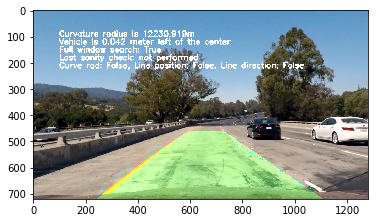

In [233]:
def draw(warped, undistorted, ploty, left_fitx, right_fitx, curverad, offset, window_search, sanity_check, curverad_check, line_position_check, line_direciton_check):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img_shape[0], img_shape[1])) 
    
    # Combine the result with the original image
    composed = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    # Build curvature string
    curverad_string = 'Curvature radius is {}m'.format(round(curverad, 3))
    
    # Build offset string
    if offset < 0:
        side = 'left'
    else:
        side = 'right'
     
    offset_string = 'Vehicle is {} meter {} of the center'.format(round(abs(offset),3), side)
    
    # Build window search string
    window_search_string = 'Full window search: {}'.format(str(window_search))
    
    # Build sanity_check string
    sanity_check_string = 'Last sanity check: {}'.format(sanity_check)
    
    # Build sanity_check detail string
    detailed_sanity_check_string = 'Curve rad: {}, Line position: {}, Line direction: {}'.format(curverad_check, line_position_check, line_direciton_check)
    
    # Add metadata
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_size = 1
    cv2.putText(composed,curverad_string,(100,100),font,font_size ,(255,255,255),thickness=4, lineType=8)
    cv2.putText(composed,offset_string,(100,130),font,font_size ,(255,255,255),thickness=4, lineType=8)
    cv2.putText(composed,window_search_string,(100,160),font,font_size,(255,255,255), thickness=4, lineType=8)
    cv2.putText(composed,sanity_check_string,(100,190),font,font_size,(255,255,255), thickness=4, lineType=8)
    cv2.putText(composed,detailed_sanity_check_string,(100,220), font,font_size, (255,255,255), thickness=4, lineType=8)
    
    return composed


composed = draw(warped, undistorted, ploty, left_fitx, right_fitx, curverad, offset, True, 'not performed', False, False, False)
plt.imshow(composed)

## Lane Class

- This python class holds fits, curve radius and offset for specific video fram based time window(currently I set it to 12). These metrics are used for sanity check, find lane in next frame. As it holds data for some time window, it is  capable for smoothing value using averaging. Particulally I applied thise strategy to fits, fits in meter,  curvature radius and offset.
- Also it holds some other attributes, those are mainly used for visualization.

In [239]:
class Lane():
    def __init__(self):
        
        self.lookback_period = 30
        
        self.ploty = None
        
        self.left_fits = []
        self.left_fits_cr = []
        self.left_fitx = []
        
        self.right_fits = []
        self.right_fits_cr = []
        self.right_fitx = []
        
        self.curverads = []
        self.offsets = []
        
        self.window_search = True
        self.last_sanity_check = ''
        self.curverad_check = False
        self.line_position_check = False
        self.line_direction_check = False
        
        
    def sanity_check(self, curverad, left_fit, right_fit):
        curverad_check = self.validate_new_curverad(curverad)
        line_position_check = self.validate_new_line_positions(left_fit, right_fit)
        line_direction_check = self.validate_new_line_directions(left_fit, right_fit)
        
        if curverad_check and line_position_check and line_direction_check:
            result = True
        else:
            result = False
            
        return result, curverad_check, line_position_check, line_direction_check
        
    def validate_new_curverad(self, new_curvature):
        if abs(new_curvature/self.averaged_curverad() - 1) < 0.5:
            return True
        else:
            return False
        
    def validate_new_line_positions(self, left_fit, right_fit):
        y_eval = np.max(self.ploty)
        left_line_position = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        right_line_position = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        distance = (right_line_position - left_line_position) * xm_per_pix
        if distance > 3.2 and distance < 4.3:
            return True
        else:
            return False
    
    def validate_new_line_directions(self, left_fit, right_fit):
        diff = abs(right_fit[0] - left_fit[0])
        if diff < 2:
            return True
        else:
            return False
    
    def add_left_fit(self, left_fit):
        if len(self.left_fits) > self.lookback_period:
            self.left_fits.pop(0)
        self.left_fits.append(left_fit)
        
    def averaged_left_fit(self):
        return np.mean(self.left_fits,axis=0)
    
    def add_right_fit(self, right_fit):
        if len(self.right_fits) > self.lookback_period:
            self.right_fits.pop(0)
        self.right_fits.append(right_fit)
        
    def averaged_right_fit(self):
        return np.mean(self.right_fits,axis=0)
    
    def add_left_fit_cr(self, left_fit_cr):
        if len(self.left_fits_cr) > self.lookback_period:
            self.left_fits_cr.pop(0)
        self.left_fits_cr.append(left_fit_cr)
        
    def averaged_left_fit_cr(self):
        return np.mean(self.left_fits_cr,axis=0)
    
    def add_right_fit_cr(self, right_fit_cr):
        if len(self.right_fits_cr) > self.lookback_period:
            self.right_fits_cr.pop(0)
        self.right_fits_cr.append(right_fit_cr)
        
    def averaged_right_fit_cr(self):
        return np.mean(self.right_fits_cr,axis=0)
                
    def add_curverad(self, curverad):
        if len(self.curverads) > self.lookback_period:
            self.curverads.pop(0)
        self.curverads.append(curverad)
        
    def averaged_curverad(self):
        return np.mean(self.curverads)
    
    def add_offset(self, offset):
        if len(self.offsets) > self.lookback_period:
            self.offsets.pop(0)
        self.offsets.append(offset)
        
    def averaged_offset(self):
        return np.mean(self.offsets)
    
    def no_previous_fits(self):
        if len(self.left_fits) == 0 and len(self.right_fits) ==0:
            return True
        else:
            return False
        
    def update(self, left_fit, left_fit_cr, left_fitx, right_fit, right_fit_cr, right_fitx, ploty, curverad, offset, window_search, last_sanity_check,curverad_check, line_position_check, line_direction_check):
        self.add_left_fit(left_fit)
        self.add_left_fit_cr(left_fit_cr)
        self.left_fitx = left_fitx

        self.add_right_fit(right_fit)
        self.add_right_fit_cr(right_fit_cr)
        self.right_fitx = right_fitx

        self.ploty = ploty

        self.add_curverad(curverad)
        self.add_offset(offset)
        
        self.window_search = window_search
        self.last_sanity_check = last_sanity_check
        self.curverad_check = curverad_check
        self.line_position_check = line_position_check
        self.line_direction_check = line_direction_check

## Pipeline

In [240]:
def pipeline(img):
    
    global lane
    
    #img = np.copy(src)
    #img_shape = (img.shape[1],img.shape[0])
    #gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
    
    # Undistort
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    #undistort = cv2.undistort(img, mtx, dist, None, mtx)
    undistorted = undistort(img)
    
    # Make binary
    binary = get_binary(undistorted)
    
    # Warp
    warped, M, M_inv = warp(binary)
    
    # Find lane and fit polynomial
    # Check if we have previous poly_fit results(which means we are cheking if this is the first frame of the video)
    if not lane.no_previous_fits():
        out_img, left_fit, right_fit, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty = search_around_poly(
            warped,
            lane.averaged_left_fit(),
            lane.averaged_right_fit()
        )
        
        # Calculate curverad and offset
        curverad = measure_curvature_real(out_img, left_fit_cr, right_fit_cr)
        offset = measure_offset(out_img, left_fit, right_fit)  
        
        # Update Lane object with window search result if results of search_around_poly sanity check fails
        sanity_check_result, curverad_check, line_position_check, line_direction_check = lane.sanity_check(
            curverad, 
            left_fit, 
            right_fit
        )
        if not sanity_check_result:
            binary = region_of_interest(binary, vertices)
            out_img, left_fit, right_fit, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty = window_search(warped)

            # Calculate curverad and offset
            curverad = measure_curvature_real(out_img, left_fit_cr, right_fit_cr)
            offset = measure_offset(out_img, left_fit, right_fit)  
            
            # Update Lane object
            lane.update(
                left_fit, 
                left_fit_cr, 
                left_fitx, 
                right_fit, 
                right_fit_cr, 
                right_fitx, 
                ploty, 
                curverad, 
                offset, 
                True, 
                'Failed',
                curverad_check,
                line_position_check,
                line_direction_check
            )
            
        # Update Lane object with search_around_poly result
        else:
            # Update Lane object
            lane.update(
                left_fit, 
                left_fit_cr, 
                left_fitx, 
                right_fit, 
                right_fit_cr, 
                right_fitx, 
                ploty, 
                curverad, 
                offset, 
                False, 
                'Succeeded',
                curverad_check,
                line_position_check,
                line_direction_check
            )
            
    else:
        # Mask
        binary = region_of_interest(binary, vertices)
        out_img, left_fit, right_fit, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty = window_search(warped)

        # Calculate curverad and offset
        curverad = measure_curvature_real(out_img, left_fit_cr, right_fit_cr)
        offset = measure_offset(out_img, left_fit, right_fit)  
        
        # Update Lane object
        lane.update(
            left_fit, 
            left_fit_cr, 
            left_fitx, 
            right_fit, 
            right_fit_cr, 
            right_fitx, 
            ploty, 
            curverad, 
            offset, 
            True, 
            'Not performed',
            False,
            False,
            False
        )
    
    # Draw lane over the soruce image
    composed = draw(
        warped, 
        undistorted, 
        lane.ploty,
        lane.left_fitx,
        lane.right_fitx,
        lane.averaged_curverad(),
        lane.averaged_offset(),
        lane.window_search,
        lane.last_sanity_check,
        lane.curverad_check,
        lane.line_position_check,
        lane.line_direction_check
    )
    
    return composed

### Tests pipeline

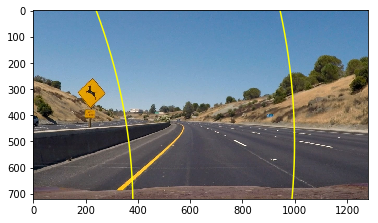

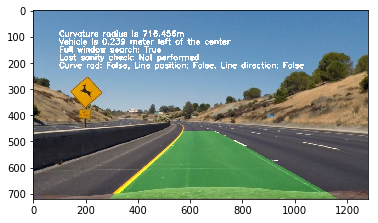

In [241]:
img1 = cv2.cvtColor(cv2.imread('test_images/test2.jpg'), cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img1)
lane = Lane()
composed = pipeline(img1)
plt.figure()
plt.imshow(composed)

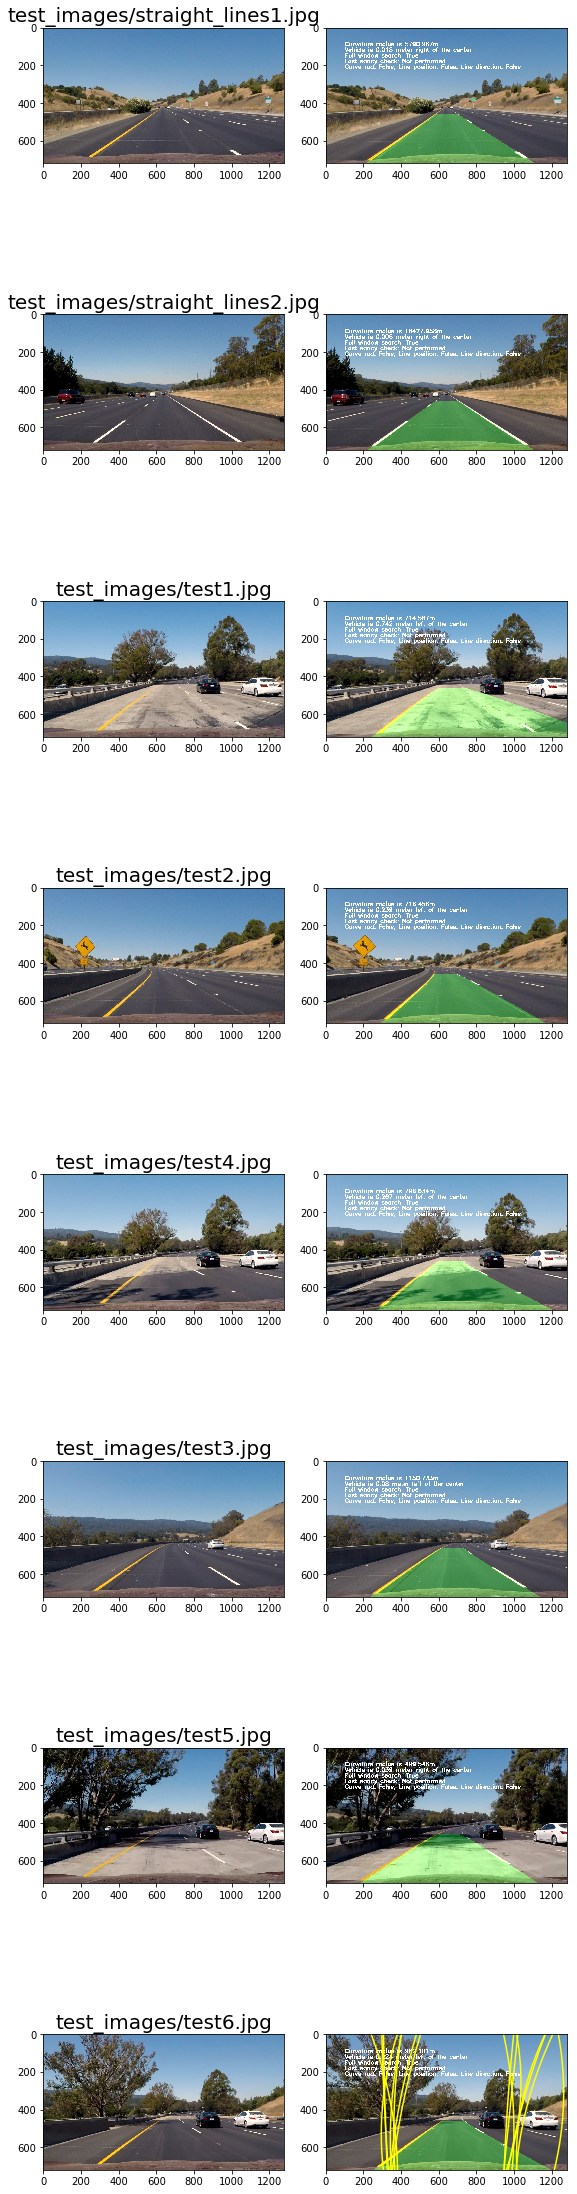

In [242]:
test_images = glob.glob('test_images/*.jpg')
fig, ax = plt.subplots(len(test_images),2,figsize=(8,32))
fig.tight_layout()

for idx, fname in enumerate(test_images):
    
    lane = Lane()
    
    # Load image
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    ax[idx,0].set_title(fname,fontsize=20)
    ax[idx,0].imshow(img)
    result = pipeline(img)
    ax[idx,1].imshow(result)

## Apply to video!

[MoviePy] >>>> Building video output3.mp4
[MoviePy] Writing video output3.mp4



100%|█████████▉| 1260/1261 [05:42<00:00,  3.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output3.mp4 

CPU times: user 3min 31s, sys: 2.87 s, total: 3min 33s
Wall time: 5min 45s


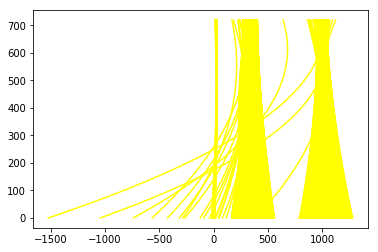

In [243]:
lane = Lane()
output = 'output3.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(20,23)
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

In [244]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))